In [1]:
# Import libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.stats import f_oneway, tukey_hsd
from wordcloud import WordCloud, STOPWORDS

# Download VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nickm\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load data file
df = pd.read_csv("data/bored_panda_posts.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2016 non-null   object 
 1   voting             2016 non-null   int64  
 2   nr_comments        1896 non-null   float64
 3   page_link          2016 non-null   object 
 4   link               2016 non-null   object 
 5   nr_postings_total  2016 non-null   int64  
 6   nr_postings_shown  2016 non-null   int64  
 7   post_id            2016 non-null   int64  
 8   is_ad              2016 non-null   bool   
 9   category_1         2007 non-null   object 
 10  category_2         1358 non-null   object 
 11  nr_authors         2016 non-null   int64  
 12  author_1           2007 non-null   object 
 13  author_2           1492 non-null   object 
 14  author_3           161 non-null    object 
 15  author_4           1 non-null      object 
 16  author_1_role      2007 

## Data Cleaning

### Drop ads

Colum "is_ad" depicts whether a posting is an advertisement or not. Those typically receive very low ratings and do not allow comments. Hence they are of no interest to this analysis and will be dropped from the dataframe.

In [3]:
df["is_ad"].sum()
# 132 ads

132

In [4]:
df[df["is_ad"]].head()

,title,voting,nr_comments,page_link,link,nr_postings_total,nr_postings_shown,post_id,is_ad,category_1,...,author_1,author_2,author_3,author_4,author_1_role,author_2_role,author_3_role,author_4_role,is_compilation,date_posted
36,Home Office Heroes: 24 Products That’ll Help Y...,-58,NaN,https://www.boredpanda.com/page/10/,https://www.boredpanda.com/shopping/office/ele...,24,24,7963845,True,Office Essentials,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2025-01-21
37,24 Fixes For Your Most Embarrassing Yet Unavoi...,-8,NaN,https://www.boredpanda.com/page/10/,https://www.boredpanda.com/shopping/beauty-sho...,24,24,8033934,True,Beauty & Self Care,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2025-01-21
52,Transforming Rentals (And Keeping Landlords Ha...,-59,NaN,https://www.boredpanda.com/page/100/,https://www.boredpanda.com/shopping/home-shopp...,21,21,7667524,True,Home & Garden,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2024-11-12
53,"23 Products With Reviews So Good, They’ll Make...",-91,NaN,https://www.boredpanda.com/page/100/,https://www.boredpanda.com/shopping/deals/thin...,23,23,7652990,True,Shopping,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2024-11-12
54,21 White Elephant Gifts That Prove Laughter Is...,-83,NaN,https://www.boredpanda.com/page/100/,https://www.boredpanda.com/shopping/funny-shop...,21,21,7601955,True,Funny And Unique Finds,...,Mariia Tkachenko,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2024-11-12


In [5]:
df[df["is_ad"]].describe()
# -> voting mean substantially negative, only 12/132 have comments

,voting,nr_comments,nr_postings_total,nr_postings_shown,post_id,nr_authors
count,132.000000,12.000000,132.000000,132.000000,1.320000e+02,132.000000
mean,-94.469697,4.916667,22.272727,22.272727,7.644108e+06,0.962121
std,69.519885,7.856188,12.406654,12.406654,5.087544e+05,0.312715
min,-348.000000,0.000000,0.000000,0.000000,5.981618e+06,0.000000
25%,-115.250000,0.000000,20.000000,20.000000,7.703989e+06,1.000000
50%,-78.500000,1.000000,22.000000,22.000000,7.834656e+06,1.000000
75%,-50.000000,7.250000,24.000000,24.000000,7.878599e+06,1.000000
max,25.000000,26.000000,100.000000,100.000000,8.063265e+06,2.000000


In [6]:
# Drop ads
print("# rows prior to dropping ads:", len(df))
df = df[df["is_ad"] == False]
print("# rows after to dropping ads:", len(df))

# rows prior to dropping ads: 2016
# rows after to dropping ads: 1884


### Missings

In [7]:
df.isna().sum()
# -> Ok! Category and Author show some missing for listings that only have 1 category/author mentioned.
# Date posted has been swiftly checked and confirmed that for these listings, no date was provided.

title                   0
voting                  0
nr_comments             0
page_link               0
link                    0
nr_postings_total       0
nr_postings_shown       0
post_id                 0
is_ad                   0
category_1              0
category_2            648
nr_authors              0
author_1                0
author_2              396
author_3             1723
author_4             1883
author_1_role           0
author_2_role         207
author_3_role        1728
author_4_role        1883
is_compilation          0
date_posted            23
dtype: int64

## Sentiment Analysis

In [8]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# create get_sentiment function
def get_sentiment(text):
    scores = sid.polarity_scores(text)
    neg = scores["neg"]
    neu = scores["neu"]
    pos = scores["pos"]
    comp = scores["compound"]
    return neg, neu, pos, comp

# apply get_sentiment function
sentiment_columns = ["sentiment_neg", "sentiment_neu", "sentiment_pos", "sentiment_compound"]
df[sentiment_columns] = df["title"].apply(get_sentiment).to_list()

In [9]:
# Show results
df.filter(["title"] + sentiment_columns).head()

,title,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,"80 Posts So Unhinged, You May End Up Laughing ...",0.000,0.802,0.198,0.4939
1,"""It Was A Warning"": Woman Receives Disturbing ...",0.231,0.769,0.000,-0.5106
2,Woman Reveals She Understood Every Insult From...,0.351,0.649,0.000,-0.7579
3,Ryan Reynolds’ “Horrifically Mean” Treatment O...,0.106,0.894,0.000,-0.0772
4,Zoe Saldaña’s Blackface Scandal Comes Back To ...,0.172,0.828,0.000,-0.4404


### Sentiment compound classification

In [10]:
# Show number of positive/negative/neutral sentiment.
print("negative (<0):", len(df[df["sentiment_compound"]<0]))
print("neutral  (=0):", len(df[df["sentiment_compound"]==0]))
print("positive (>0):", len(df[df["sentiment_compound"]>0]))

negative (<0): 731
neutral  (=0): 357
positive (>0): 796


In [11]:
# Create column with final sentiment
def sentiment_classification(value):
    if value > 0: return "positive"
    if value < 0: return "negative"
    return "neutral"

df["sentiment"] = df["sentiment_compound"].apply(sentiment_classification)
df["sentiment"].value_counts()

sentiment
positive    796
negative    731
neutral     357
Name: count, dtype: int64

In [12]:
# See which column attributes the max value.
df.filter(["sentiment_neg", "sentiment_neu", "sentiment_pos"]).idxmax(axis=1).value_counts()

sentiment_neu    1850
sentiment_pos      20
sentiment_neg      14
Name: count, dtype: int64

## Data Preparation

### Date type columns

In [13]:
# Reformat column to datetime type
print(df['date_posted'].dtype)
df['date_posted_reformatted'] = pd.to_datetime(df["date_posted"], format="%Y-%m-%d")
print(df['date_posted_reformatted'].dtype)
df.filter(like="date").head()

object
datetime64[ns]


,date_posted,date_posted_reformatted
0,2025-01-27,2025-01-27
1,2025-01-27,2025-01-27
2,2025-01-27,2025-01-27
3,2025-01-27,2025-01-27
4,2025-01-27,2025-01-27


In [14]:
print("Unique dates: ", len(df["date_posted_reformatted"].unique()))
print("Earliest date:", df["date_posted_reformatted"].min())
print("Latest date:  ", df["date_posted_reformatted"].max())

Unique dates:  80
Earliest date: 2024-10-31 00:00:00
Latest date:   2025-01-27 00:00:00


### Categorical Columns

In this section, additional dataframes will be created storing values for the columns associated with categories and authors. The data will be stored in long format to account for multiple categories/authors listed. Alongside the post_id and an index, Sentiment will remain the only variable in the long format dataframe.

#### Categories

In [15]:
# Reset index and create colum "index" for id_var in melt command
df = df.reset_index(drop=True)
df["index"] = df.index

# Transform df into long format
df_cat_long = pd.melt(df, id_vars=["post_id", "index", "sentiment"], 
                      value_vars=["category_1", "category_2"],
                      var_name="cat",
                      value_name="Category")

# Drop created var_name column
df_cat_long = df_cat_long.drop(["cat"], axis=1)
# Sort by "index" (original df.index)
df_cat_long = df_cat_long.sort_values(by="index")
# Drop rows that are NaN in Category column due to only being assigned 1 category.
df_cat_long = df_cat_long[df_cat_long["Category"].isna() == False]

df_cat_long

,post_id,index,sentiment,Category
0,8078562,0,positive,Curiosities
1,8090374,1,negative,Lifestyle
1885,8090374,1,negative,News
2,8077890,2,negative,Family
1886,8077890,2,negative,Relationships
...,...,...,...,...
1880,7696020,1880,neutral,Celebrities
1881,7691746,1881,neutral,Art
3766,7646576,1882,neutral,Funny
1882,7646576,1882,neutral,Comics


In [16]:
# Show unique values / counts
df_cat_long["Category"].value_counts()
# 68 unique values

Category
Relationships    385
News             250
Family           242
Funny            179
Curiosities      160
                ... 
Decorating         1
Sleep              1
Gardening          1
Halloween          1
Organizing         1
Name: count, Length: 68, dtype: int64

In [17]:
# Observe categories with low counts to group in "others"
category_counts = df_cat_long["Category"].value_counts().to_frame()
print("Nr. catogries appearing in more than...")
print("10 postings:", sum(category_counts["count"] >= 10))
print("20 postings:", sum(category_counts["count"] >= 20))
print("Nr. catogries to be grouped in 'Others' with less than...")
print("10 postings:", category_counts.loc[category_counts["count"] < 10, "count"].sum())
print("20 postings:", category_counts.loc[category_counts["count"] < 20, "count"].sum())

Nr. catogries appearing in more than...
10 postings: 41
20 postings: 30
Nr. catogries to be grouped in 'Others' with less than...
10 postings: 97
20 postings: 257


In [18]:
# Set threshold and extract names of those categories being grouped in "others" in next step.
others_names = category_counts[category_counts["count"] < 10].index.to_list()
others_names[:10]

['Work',
 'Tech&Science',
 'Community AITA',
 'Digital Art',
 'Needle and Thread',
 'Architecture',
 'Movies&TV',
 'Mental health',
 'Sports',
 'Beauty']

In [19]:
# Group categories with low count in "Other"
df_cat_long["Category Shortened"] = (df_cat_long["Category"]
                                     .apply(lambda x: "Other" if x in others_names else x))
df_cat_long["Category Shortened"].value_counts()

Category Shortened
Relationships      385
News               250
Family             242
Funny              179
Curiosities        160
Entertainment      155
Social Issues      152
Entitled People    134
Couples            112
Art                104
Celebrities        102
Other               97
Comics              93
Funny Memes         88
Work & Money        80
Animals             73
Fails               61
Wholesome           53
Parenting           44
Movies & tv         44
Photography         42
Friends             41
Dogs                36
Occasions           35
Crime               35
Health              33
US                  27
History             26
Community           26
Jokes               26
Cats                25
Home & Design       19
Christmas           17
Wedding             16
Lifestyle           16
Facts               16
Ask Pandas          15
World               15
Food                13
Tattoos             12
Travel              11
Feminism            10
Name: count, dt

In [20]:
# Create count column
df_cat_long["count"] = (df_cat_long["Category Shortened"]
                        .map(df_cat_long["Category Shortened"].value_counts()))

#### Authors

In [21]:
# 1. Transform df into long format - AUTHORS' NAMES
author_cols = ['author_1', 'author_2', 'author_3', 'author_4']
df_author_long = pd.melt(df, id_vars=["post_id", "index", "sentiment", "nr_authors"], 
                         value_vars=author_cols,
                         var_name="author_id",
                         value_name="Author Name")

# 2. Transform df into long format - AUTHORS' ROLES
author_role_cols = ['author_1_role', 'author_2_role', 'author_3_role', 'author_4_role']
df_author_role_long = pd.melt(df, id_vars=["post_id", "index", "sentiment", "nr_authors"], 
                              value_vars=author_role_cols,
                              var_name="author_id",
                              value_name="Author Role")

# 3. "merge", i.e. add Author Role to sorted(!) df
df_author_long = df_author_long.sort_values(by=["post_id", "author_id"])
df_author_role_long = df_author_role_long.sort_values(by=["post_id", "author_id"])
df_author_long["Author Role"] = df_author_role_long["Author Role"]

# Sort by "index" (original df.index)
df_author_long = df_author_long.sort_values(by=["index", "author_id"])

# Drop rows that are NaN in both new author columns.
df_author_long = (df_author_long[(df_author_long["Author Name"].isna() == False)
                                 | (df_author_long["Author Role"].isna() == False)])

# Strip white space from Author columns
df_author_long["Author Name"] = df_author_long["Author Name"].str.strip()
df_author_long["Author Role"] = df_author_long["Author Role"].str.strip()
df_author_long["Author Role"] = df_author_long["Author Role"].str.replace("  ", " ")

df_author_long

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
0,8078562,0,positive,2,author_1,Adelaide Ross,"Writer, BoredPanda staff"
1884,8078562,0,positive,2,author_2,Ieva Pečiulytė,"Author, BoredPanda staff"
1,8090374,1,negative,2,author_1,Binitha Jacob,"Writer, BoredPanda staff"
1885,8090374,1,negative,2,author_2,Donata Leskauskaite,"Author, BoredPanda staff"
2,8077890,2,negative,2,author_1,Nikita Manot,"Writer, BoredPanda staff"
...,...,...,...,...,...,...,...
3765,7691746,1881,neutral,1,author_2,NaN,"Moderator, BoredPanda staff"
1882,7646576,1882,neutral,1,author_1,Michael Samuels,"Author, Community member"
3766,7646576,1882,neutral,1,author_2,NaN,"Moderator, BoredPanda staff"
1883,7652004,1883,positive,1,author_1,Hidrėlėy,"Author, Pro member"


In [22]:
# Check reshaped dataframe's size for plausability
print(4*len(df) - df.filter(author_cols).isna().sum().sum())
print(4*len(df) - df.filter(author_role_cols).isna().sum().sum())

3534
3718


In [23]:
# Check Author Roles for missing Author Names
df_author_long.loc[df_author_long["Author Name"].isna(), "Author Role"].value_counts()

Author Role
Moderator, BoredPanda staff    188
Author, Community member         1
Name: count, dtype: int64

In [24]:
# Most of them are "Moderators", perhaps mentioned without a name.
# 1 is an Author, this case should be checked again
check_id = (df_author_long.loc[(df_author_long["Author Name"].isna()) 
                               & (df_author_long["Author Role"] == "Author, Community member"),
                               "post_id"]).values[0]
df[df["post_id"] == check_id].filter(like="auth")

,nr_authors,author_1,author_2,author_3,author_4,author_1_role,author_2_role,author_3_role,author_4_role
1813,1,By Deleted User,NaN,NaN,NaN,"Moderator, BoredPanda staff","Author, Community member",NaN,NaN


In [25]:
df_author_long.loc[df_author_long["post_id"] == check_id]

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
1813,7701247,1813,positive,1,author_1,By Deleted User,"Moderator, BoredPanda staff"
3697,7701247,1813,positive,1,author_2,NaN,"Author, Community member"


In [26]:
# Looks like here, a moderator took over after the author deleted their profile.
# -> Swap this
df_author_long.loc[(df_author_long["post_id"] == check_id) & 
                   (df_author_long["author_id"] == "author_1"), "Author Role"] = "Author, Community member"

df_author_long.loc[(df_author_long["post_id"] == check_id) & 
                   (df_author_long["author_id"] == "author_2"), "Author Role"] = pd.NA

df_author_long.loc[df_author_long["post_id"] == check_id]

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
1813,7701247,1813,positive,1,author_1,By Deleted User,"Author, Community member"
3697,7701247,1813,positive,1,author_2,NaN,<NA>


In [27]:
# Check roles for missing names again
df_author_long.loc[df_author_long["Author Name"].isna(), "Author Role"].value_counts()

Author Role
Moderator, BoredPanda staff    188
Name: count, dtype: int64

In [28]:
# Drop rows where Author Name is NA
print(len(df_author_long))
df_author_long = df_author_long[df_author_long["Author Name"].isna() == False]
print(len(df_author_long))

3723
3534


In [29]:
# Check missings
df_author_long.isna().sum()

post_id        0
index          0
sentiment      0
nr_authors     0
author_id      0
Author Name    0
Author Role    5
dtype: int64

In [30]:
# 5 postings with missing author role
df_author_long[df_author_long["Author Role"].isna()]

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
4197,7948432,429,positive,3,author_3,Rude_Welcome_3269,NaN
4298,7948149,530,negative,3,author_3,Dismylik16thaccount,NaN
4410,7914256,642,positive,3,author_3,ENMR-OG,NaN
4478,7914315,710,neutral,3,author_3,Wizo_Muc,NaN
4597,7890529,829,negative,3,author_3,Infinite-Minute2004,NaN


In [31]:
# Unclear. Potentially "Member", but to be sure, remove those rows, too.
print(len(df_author_long))
df_author_long = df_author_long[df_author_long["Author Role"].isna() == False]
print(len(df_author_long))

3534
3529


##### Author Names

In [32]:
df_author_long["Author Name"].value_counts()
# 115 unique authors

Author Name
Hidrėlėy             146
Monika Pašukonytė    130
Rūta Zumbrickaitė    113
Justin Sandberg      105
Adelaide Ross        104
                    ... 
JunebugWeddings        1
Linas Jokubaitis       1
Creare                 1
Lisa D'Amico PhD       1
Michael Samuels        1
Name: count, Length: 115, dtype: int64

In [33]:
author_name_count = df_author_long["Author Name"].value_counts().to_frame()
print("Nr. authors with more than...")
print("10 postings:", sum(author_name_count["count"] >= 10))
print("20 postings:", sum(author_name_count["count"] >= 20))

Nr. authors with more than...
10 postings: 62
20 postings: 53


In [34]:
others_names = author_name_count[author_name_count["count"] < 10].index.to_list()
others_names[:5]

['Gabriela Zagórska',
 'Zo Aguila',
 'Ingrida Jasiukevičiūtė',
 'All About Photo',
 'Damanjeet Sethi']

In [35]:
df_author_long["Author Name Shortened"] = (df_author_long["Author Name"]
                                           .apply(lambda x: "Other" if x in others_names else x))
df_author_long["Author Name Shortened"].value_counts()

Author Name Shortened
Hidrėlėy                146
Monika Pašukonytė       130
Rūta Zumbrickaitė       113
Justin Sandberg         105
Adelaide Ross           104
                       ... 
Ieva Midveryte           13
Julija B.                13
Aurelija Rakauskaitė     12
Eglė Bliabaitė           11
Donata Ruzgaitė          10
Name: count, Length: 63, dtype: int64

In [36]:
# Create count column
df_author_long["author_count"] = (df_author_long["Author Name Shortened"]
                                  .map(df_author_long["Author Name Shortened"].value_counts()))

##### Author Role

In [37]:
df_author_long["Author Role"].value_counts()

Author Role
Author, BoredPanda staff       1808
Writer, BoredPanda staff       1455
Author, Pro member              146
Author, Community member         82
Moderator, BoredPanda staff      38
Name: count, dtype: int64

In [38]:
# Create count column
df_author_long["role_count"] = (df_author_long["Author Role"]
                                .map(df_author_long["Author Role"].value_counts()))

## Exploratory Data Analysis

### Top/Bottom Titles

In [39]:
# Show entries with strongest negative sentiment.
df.sort_values(by="sentiment_compound").filter(sentiment_columns + ["title"]).head(5)

,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,title
255,0.567,0.433,0.0,-0.9371,"""Dance On Her Grave"": Cruel Stepmother Nears D..."
144,0.397,0.603,0.0,-0.9042,Employee Makes Up An Evil Plan To Find Out And...
1480,0.503,0.497,0.0,-0.9032,“They Died?? I Thought They Fell Asleep!”: 50 ...
556,0.498,0.502,0.0,-0.8979,“Please Hate These Things”: 30 Design Disaster...
1003,0.476,0.524,0.0,-0.8957,Man Sick Of Mom And Sis Mocking His Wife’s Nam...


In [40]:
# Show most positive entries.
df.sort_values(by="sentiment_compound", ascending=False).filter(sentiment_columns + ["title"]).head(5)

,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,title
912,0.000,0.427,0.573,0.9246,Folks Share The Best Cat Smiles They’ve Ever B...
1212,0.062,0.449,0.489,0.9246,"These Baby Opossums Lost Their Mom, But The Re..."
698,0.000,0.359,0.641,0.9231,30 Beautiful Creations Inspired by Nature That...
1021,0.000,0.409,0.591,0.9186,45 Of The Funniest Cat Bleps Guaranteed To Bri...
1188,0.000,0.512,0.488,0.9081,40 Funny Tinder Chats That Might Not Have Ende...


In [41]:
# Show some entries with neutral sentiment value.
df.loc[df["sentiment_compound"]==0, sentiment_columns + ["title"]].sample(5, random_state=42)

,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,title
1138,0.000,1.000,0.000,0.0,“I Can Smell These In Someone From Several Fee...
276,0.000,1.000,0.000,0.0,50 Posts From “Facts For Genius” That Might Te...
1471,0.000,1.000,0.000,0.0,Simone Biles Husband: Meet The NFL Star Who St...
1538,0.238,0.524,0.238,-0.0,50 People Who Probably Had A Worse Day Than Yo...
319,0.000,1.000,0.000,0.0,“Within A Month I’d Moved Out”: 37 Reasons Peo...


In [42]:
# Show titles with most comments
df["nr_comments"] = df["nr_comments"].astype(int)
show_cols = ["title", "voting", "nr_comments", "category_1", "category_2", "is_compilation", "sentiment"]

pd.set_option('display.max_colwidth', None)

df.filter(show_cols).sort_values(by="nr_comments", ascending=False).head(10)

,title,voting,nr_comments,category_1,category_2,is_compilation,sentiment
1126,"Vegetarian Mom Fears Family Will Feed Baby Meat Behind Her Back, Seeks Perspective Online",24,135,Parenting,NaN,False,negative
433,50 Screenshots Of Americans Being Peak Dumb That May Make You Feel Like A Genius (New Pics),38,134,Fails,Funny,True,negative
435,"Time’s Up: Serial Latecomer Pushes Friend To Snap, Leaves Lunch Date Without A Word",36,134,Friends,Relationships,False,positive
235,Meta Workers Left In “Shock And Disbelief” Amid Mark Zuckerberg’s Controversial LGBTQ+ Changes,18,130,Celebrities,News,False,negative
1845,Couple Get $3000 In Gifts From Their $60k Wedding: “We’re Freaking Out And Really Devastated”,-11,130,Occasions,Wedding,False,negative
580,"Dad Saves Son From Lifetime Of Bullying By Giving Him Regular Name, Sparks Grandma’s Rage",57,128,Family,Relationships,False,negative
699,"Netizens Point Out The 37 Biggest Movies They’ll Never Re-Watch Again, Under Any Circumstances",77,122,Entertainment,Movies & tv,True,neutral
54,Here Are 23 Canceled TV Shows And You Decide Whether They Deserve To Come Back,15,119,Entertainment,Movies & tv,True,neutral
1551,Diner Starts Debate After Waiter Rejects $25 Tip: “Tipping Culture Has Gotten Out Of Hand”,13,117,Entitled People,Social Issues,False,negative
1446,"“Super Cute, Right?” She Dressed Up For A Date, Then His First Comment Shattered Everything",17,113,News,Relationships,False,negative


In [43]:
# Show titles with highest voting
df.filter(show_cols).sort_values(by="voting", ascending=False).head(10)

,title,voting,nr_comments,category_1,category_2,is_compilation,sentiment
1616,50 Wholesome “Eye Bleach” Pics To Cleanse Your Eyes From The Horrors Of The Internet,241,42,Wholesome,NaN,True,negative
1625,50 Epic Comments That Were Better Than The Post (New Pics),213,47,Funny,Jokes,True,positive
1117,"If You Feel Like The World Is Going To Hell, These 50 Positive Stories May Change Your Mind",190,23,Wholesome,NaN,True,positive
50,50 Memes That Cat Owners Might Find Relatable,186,22,Funny,Funny Memes,True,neutral
130,50 Delightful Animal Memes To Help You Ignore What’s Happening In The World Right Now,173,19,Funny,Funny Memes,True,positive
1770,50 Hilarious Memes That Display British Humor At Its Finest,171,13,Funny,Funny Memes,True,positive
575,50 Cats That May Leave You Laughing So Hard You’ll Forget All Your Worries For A Minute (New Pics),170,21,Animals,Cats,True,negative
964,50 ‘Blessed Images’ That May Turn Your Day Around For The Better (New Pics),168,10,Wholesome,NaN,True,positive
1106,50 Wholesome Pics From The “Wholesome Meets The Internet” Account To Brighten Up Your Day (New Pics),160,11,Wholesome,NaN,True,positive
992,People Who’ve Mastered The Art Of Outwitting Felines Share Their Best Ever Cat Traps,155,25,Animals,Cats,True,positive


In [44]:
# Show titles with lowest voting
df.filter(show_cols).sort_values(by="voting", ascending=True).head(10)

,title,voting,nr_comments,category_1,category_2,is_compilation,sentiment
705,20 Stars Whose Dramatic Transformations Had Everyone Talking This Year,-184,28,Celebrities,News,True,neutral
1880,Who Is Sydney Sweeney’s Fiancé? A Glimpse Into Her Relationship With Jonathan Davino,-171,25,Celebrities,Entertainment,False,neutral
206,Kim Kardashian Kids: What We Know About Her Four Children,-127,14,Celebrities,Entertainment,False,neutral
1250,Who Is Kim Kardashian Dating? A Timeline Of Her Relationships,-123,10,Celebrities,Entertainment,False,neutral
1266,"AI Gives 18 Male Celebrities A Gender Swapped Look, Here’s The Result",-120,27,Celebrities,Entertainment,True,neutral
515,15 Celebrities Who Were Caught In Scandalous Affairs In 2024,-101,13,Celebrities,News,True,negative
550,30 Red Carpet Looks That Got It Wrong In 2024,-100,16,Celebrities,News,True,negative
548,Baby’s Appearance Prompted Mom To Seek DNA Test: “My Son Was Really Ugly”,-80,55,Family,News,False,neutral
511,From Luigi Mangione To Keanu Reeves: 31 Viral Mugshots Of Criminal Heartthrobs,-79,30,Crime,News,True,negative
890,"After Dad Takes Own Life Looking For Her, Hannah Kobayashi Now Wants To Focus On Her Creativity",-76,17,News,US,False,positive


### Voting, Comments, and Avg compound per Category and Author

In [45]:
# Define helper function for printing top x entries
def print_top_bottom_n(df, column, n):
    print(f"Top {n} entries by column {column}:")
    print(df.sort_values(by=column, ascending=False).head(n))
    print(f"\nBottom {n} entries by column {column}:")
    print(df.sort_values(by=column, ascending=False).tail(n))

#### Categories

In [46]:
# Add compound, voting, and comments to long df
df_cat_long = df_cat_long.merge(df[["post_id", "sentiment_compound", "nr_comments", "voting"]], on="post_id")
df_cat_long.head()

,post_id,index,sentiment,Category,Category Shortened,count,sentiment_compound,nr_comments,voting
0,8078562,0,positive,Curiosities,Curiosities,160,0.4939,6,61
1,8090374,1,negative,Lifestyle,Lifestyle,16,-0.5106,4,26
2,8090374,1,negative,News,News,250,-0.5106,4,26
3,8077890,2,negative,Family,Family,242,-0.7579,29,31
4,8077890,2,negative,Relationships,Relationships,385,-0.7579,29,31


In [47]:
df_cat_long_agg = (df_cat_long.groupby(["Category Shortened"])
                      .agg({"Category Shortened": "count",
                            "sentiment_compound": "mean",
                            "voting": "mean",
                            "nr_comments": "mean"}))
df_cat_long_agg = df_cat_long_agg.rename(columns={"Category Shortened": "count"})
df_cat_long_agg.head()

,count,sentiment_compound,voting,nr_comments
Category Shortened,,,,
Animals,73,0.268181,74.904110,11.383562
Art,104,0.291096,49.615385,7.413462
Ask Pandas,15,0.214447,15.200000,2.866667
Cats,25,0.249736,88.760000,12.880000
Celebrities,102,0.006580,-10.127451,12.990196


In [48]:
for col in ["sentiment_compound", "voting", "nr_comments"]:
    print_top_bottom_n(df_cat_long_agg, "sentiment_compound", 5)
    print("\n")

Top 5 entries by column sentiment_compound:
                    count  sentiment_compound     voting  nr_comments
Category Shortened                                                   
Facts                  16            0.416812  76.250000    15.437500
Photography            42            0.403590  58.428571     6.619048
Jokes                  26            0.383762  90.961538    23.000000
History                26            0.382473  78.653846    10.692308
Comics                 93            0.377199  38.860215     3.333333

Bottom 5 entries by column sentiment_compound:
                    count  sentiment_compound     voting  nr_comments
Category Shortened                                                   
Social Issues         152           -0.213723  38.447368    31.217105
Feminism               10           -0.214350  31.400000    43.200000
Family                242           -0.215994  38.954545    36.739669
US                     27           -0.247959  14.518519    34.70370

#### Authors

In [49]:
# Add compound, voting, and comments to long df
df_author_long = df_author_long.merge(df[["post_id", "sentiment_compound", "nr_comments", "voting"]], on="post_id")
df_author_long.head()

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role,Author Name Shortened,author_count,role_count,sentiment_compound,nr_comments,voting
0,8078562,0,positive,2,author_1,Adelaide Ross,"Writer, BoredPanda staff",Adelaide Ross,104,1455,0.4939,6,61
1,8078562,0,positive,2,author_2,Ieva Pečiulytė,"Author, BoredPanda staff",Ieva Pečiulytė,70,1808,0.4939,6,61
2,8090374,1,negative,2,author_1,Binitha Jacob,"Writer, BoredPanda staff",Binitha Jacob,45,1455,-0.5106,4,26
3,8090374,1,negative,2,author_2,Donata Leskauskaite,"Author, BoredPanda staff",Donata Leskauskaite,49,1808,-0.5106,4,26
4,8077890,2,negative,2,author_1,Nikita Manot,"Writer, BoredPanda staff",Nikita Manot,51,1455,-0.7579,29,31


In [50]:
df_author_long_agg = (df_author_long.groupby(["Author Name Shortened"])
                      .agg({"Author Name Shortened": "count",
                            "sentiment_compound": "mean",
                            "nr_comments": "mean",
                            "voting": "mean"}))
df_author_long_agg = df_author_long_agg.rename(columns={"Author Name Shortened": "count"})
df_author_long_agg.head()

,count,sentiment_compound,nr_comments,voting
Author Name Shortened,,,,
Abel Musa Miño,45,0.004476,16.888889,19.866667
Adelaide Ross,104,-0.009198,28.038462,52.125000
Andréa Oldereide,65,-0.220251,28.061538,16.384615
Aurelija Rakauskaitė,12,0.115625,11.666667,82.083333
Austeja Zokaite,77,0.006462,25.636364,58.207792


In [51]:
for col in ["sentiment_compound", "voting", "nr_comments"]:
    print_top_bottom_n(df_author_long_agg, "sentiment_compound", 5)
    print("\n")

Top 5 entries by column sentiment_compound:
                       count  sentiment_compound  nr_comments     voting
Author Name Shortened                                                   
Ieva Midveryte            13            0.483715     3.692308  41.615385
Community Panda           38            0.369716     4.052632  35.736842
Hidrėlėy                 146            0.359209     5.006849  46.034247
Dominykas Zukas           26            0.332969     6.500000  67.961538
Gabrielė Malukaitė        16            0.305606     3.187500  36.875000

Bottom 5 entries by column sentiment_compound:
                       count  sentiment_compound  nr_comments     voting
Author Name Shortened                                                   
Donata Leskauskaite       49           -0.178941    27.714286   8.530612
Monica Selvi              42           -0.185829    26.500000  40.952381
Ifeoluwa Adesina          31           -0.192852    26.870968  38.032258
Karina Babenok            49    

## Statistical Analysis of Numeric Columns

### Run F-Test comparison for the 3 groups of sentiment (positive, negative, neutral)

In [52]:
# F-Test
df["is_compilation_int"] = df["is_compilation"].astype(int)
numeric_columns_dict = {'voting': "Voting",
                        'nr_comments': "# Comments",
                        'nr_postings_shown': "# Postings",
                        'nr_authors': "# Authors",
                        'is_compilation_int': "Is compilation"}

print(f'{"Column":20}{"F1-Stat":10}{"F1 p-value"}')
for col in numeric_columns_dict.keys():
    # Filter data
    pos_data = df.loc[df["sentiment"] == "positive", col]
    neg_data = df.loc[df["sentiment"] == "negative", col]
    neu_data = df.loc[df["sentiment"] == "neutral", col]
    # F-Test
    f1 = f_oneway(pos_data, neg_data, neu_data)
    f1_stat, f1_pval = round(f1[0], 3), round(f1[1], 3)

    print(f"{col:20}{f1_stat:.3f}{f1_pval:9.3f}")

Column              F1-Stat   F1 p-value
voting              32.016    0.000
nr_comments         57.551    0.000
nr_postings_shown   52.515    0.000
nr_authors          35.250    0.000
is_compilation_int  56.441    0.000


### Perform Tukey's HSD Test

In [53]:
# Initiate dataframe to store results in
k = len(numeric_columns_dict.values())

stat_results = pd.DataFrame({
    "Variable": np.repeat(list(numeric_columns_dict.keys()),2).tolist(),
    "Stats": ["Statistic", "p-Value"]*k,
    "All": [pd.NA]*k*2,
    "0-1": [pd.NA]*k*2,
    "0-2": [pd.NA]*k*2,
    "1-2": [pd.NA]*k*2,
})

# F-Test and Tukey's HSD Test
for col in numeric_columns_dict.keys():
    # Filter data
    pos_data = df.loc[df["sentiment"] == "positive", col]
    neg_data = df.loc[df["sentiment"] == "negative", col]
    neu_data = df.loc[df["sentiment"] == "neutral", col]
    # F-Test
    f1 = f_oneway(pos_data, neg_data, neu_data)
    f1_stat, f1_pval = round(f1[0], 3), round(f1[1], 3)
    # Tukey's HSD Test
    tukey = tukey_hsd(pos_data, neg_data, neu_data)
    tukey_stat = abs(tukey.statistic[[0,0,1], [1,2,2]]).round(3)
    tukey_pval = tukey.pvalue[[0,0,1], [1,2,2]].round(3)
    # Store results
    stat_results.loc[(stat_results["Variable"]==col) & 
                     (stat_results["Stats"]=="Statistic"), 
                     ["All", "0-1", "0-2", "1-2"]] = [f1_stat]+tukey_stat.tolist()
    stat_results.loc[(stat_results["Variable"]==col) & 
                     (stat_results["Stats"]=="p-Value"), 
                     ["All", "0-1", "0-2", "1-2"]] = [f1_pval]+tukey_pval.tolist()
    
# Transform result df
stat_results["Variable"] = stat_results["Variable"].map(numeric_columns_dict)

stat_results_T = stat_results.set_index(["Variable","Stats"]).T
stat_results_T.index = ["Pos vs. Neg vs. Neut", "Pos vs. Neg", "Pos vs. Neut", "Neg vs. Neut"]

pd.options.display.float_format = '{:.3f}'.format
stat_results_T

Variable                Voting         # Comments         # Postings           
Stats                Statistic p-Value  Statistic p-Value  Statistic p-Value   
Pos vs. Neg vs. Neut    32.016   0.000     57.551   0.000     52.515   0.000  \
Pos vs. Neg             11.087   0.000     11.396   0.000      9.880   0.000   
Pos vs. Neut            14.353   0.000      4.805   0.001      7.077   0.000   
Neg vs. Neut             3.265   0.280      6.591   0.000      2.803   0.062   

Variable             # Authors         Is compilation          
Stats                Statistic p-Value      Statistic p-Value  
Pos vs. Neg vs. Neut    35.250   0.000         56.441   0.000  
Pos vs. Neg              0.194   0.000          0.264   0.000  
Pos vs. Neut             0.037   0.497          0.139   0.000  
Neg vs. Neut             0.231   0.000          0.124   0.000

## Data Visualization

### Numeric Columns

In [54]:
# Define columns to plot
df["is_compilation_int"] = df["is_compilation"].astype(int)
numeric_columns_dict = {'voting': "Voting",
                        'nr_comments': "# Comments",
                        'nr_postings_shown': "# Postings",
                        'nr_authors': "# Authors",
                        'is_compilation_int': "Is compilation"}

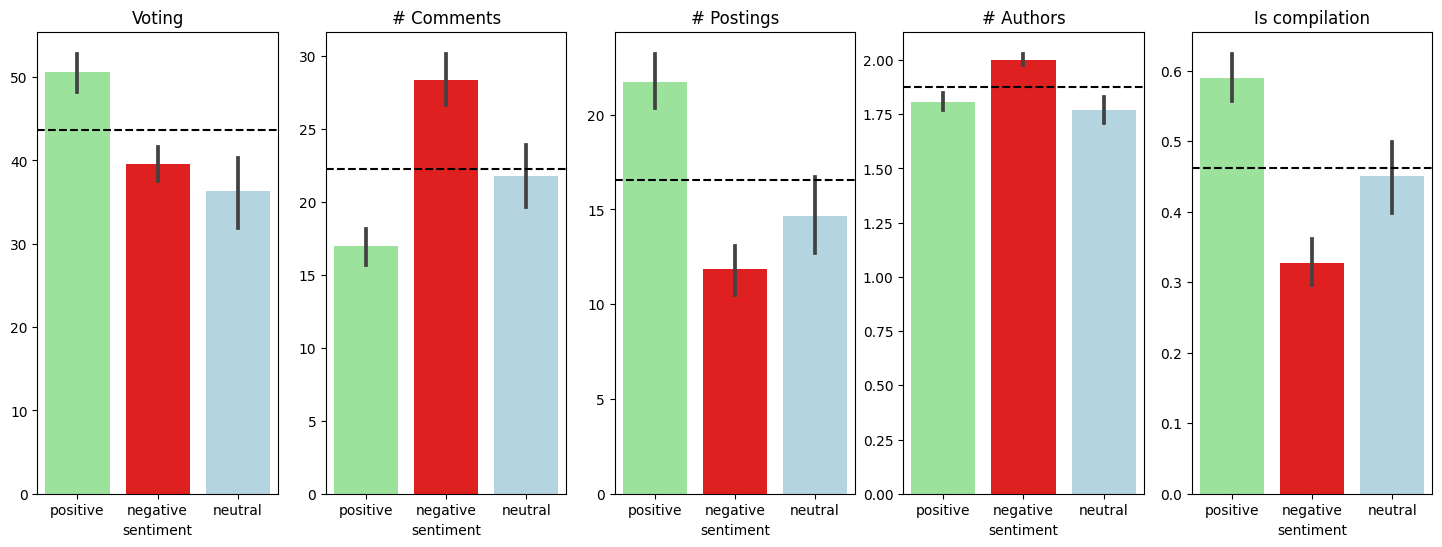

In [55]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=len(numeric_columns_dict))

for axis, col in enumerate(numeric_columns_dict.keys()):
    sns.barplot(data=df, 
                x="sentiment", 
                y=col, 
                order=["positive", "negative", "neutral"],
                palette=["lightgreen", "red", "lightblue"], 
                ax=axs[axis])
    axs[axis].set_title(numeric_columns_dict[col])
    axs[axis].axhline(df[col].mean(), color="black", linestyle="--")
    axs[axis].set_ylabel(None)

In [56]:
# Show statistical analysis from above again
stat_results_T

Variable                Voting         # Comments         # Postings           
Stats                Statistic p-Value  Statistic p-Value  Statistic p-Value   
Pos vs. Neg vs. Neut    32.016   0.000     57.551   0.000     52.515   0.000  \
Pos vs. Neg             11.087   0.000     11.396   0.000      9.880   0.000   
Pos vs. Neut            14.353   0.000      4.805   0.001      7.077   0.000   
Neg vs. Neut             3.265   0.280      6.591   0.000      2.803   0.062   

Variable             # Authors         Is compilation          
Stats                Statistic p-Value      Statistic p-Value  
Pos vs. Neg vs. Neut    35.250   0.000         56.441   0.000  
Pos vs. Neg              0.194   0.000          0.264   0.000  
Pos vs. Neut             0.037   0.497          0.139   0.000  
Neg vs. Neut             0.231   0.000          0.124   0.000

### Date Posted

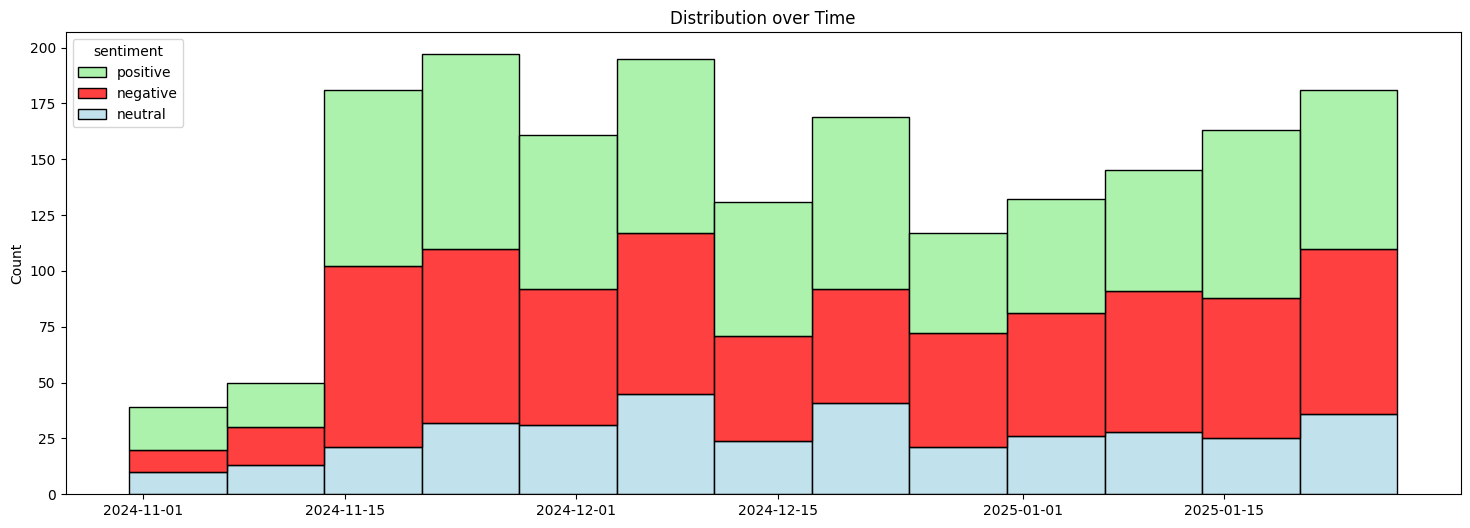

In [57]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.histplot(data=df, 
             x="date_posted_reformatted", 
             hue="sentiment", 
             hue_order=["positive", "negative", "neutral"],
             palette=["lightgreen", "red", "lightblue"],
             multiple="stack")
ax.set_title("Distribution over Time")
ax.set_xlabel(None);

### Categories

In [58]:
# Sort by count and Category Name
df_cat_long = df_cat_long.sort_values(by=["count", "Category Shortened"], ascending=False)
df_cat_long_agg = df_cat_long_agg.sort_values(by="count", ascending=False)

In [59]:
df_cat_long_agg["count"]["News"]

250

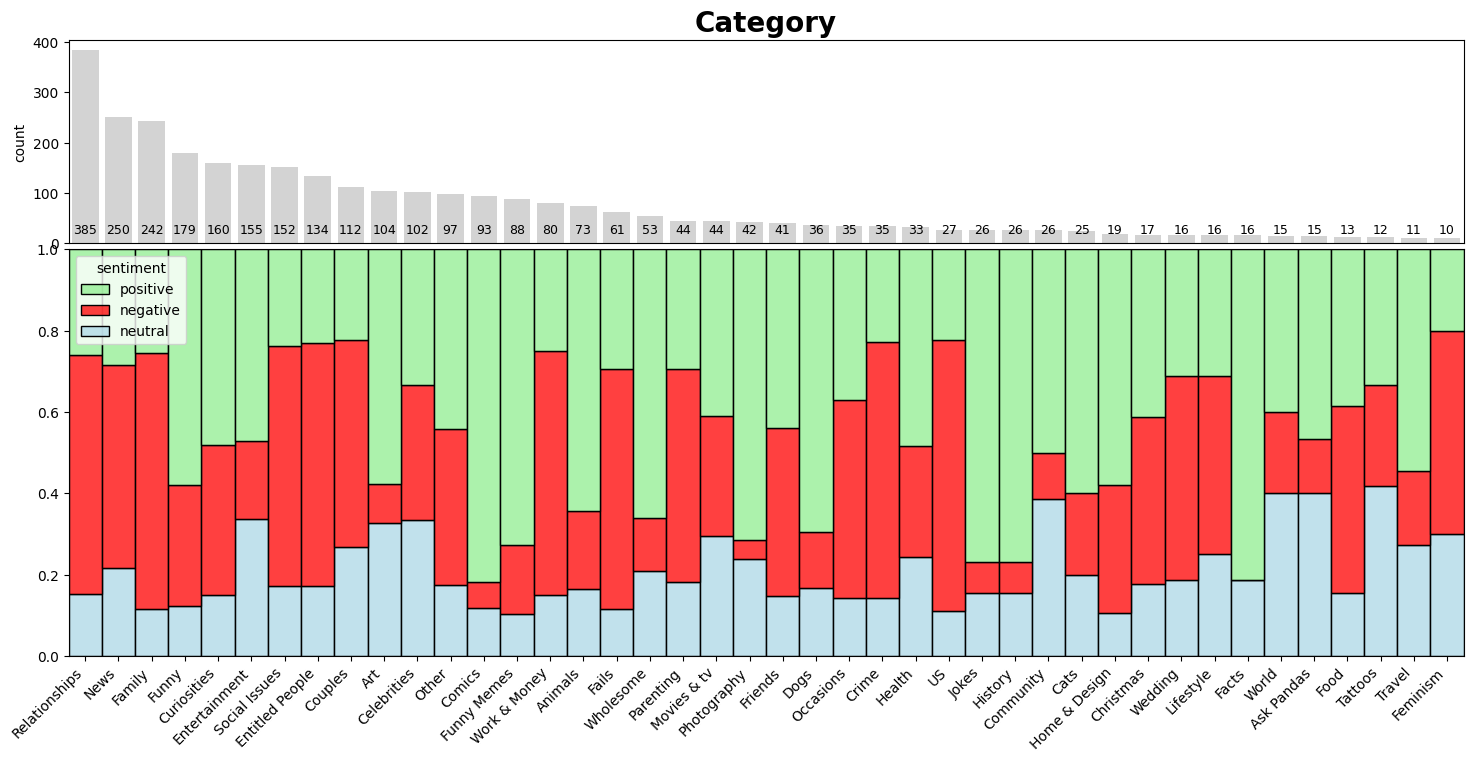

In [60]:
fig, axs = plt.subplots(figsize=(18,8), height_ratios=[4, 8], nrows=2)
plt.subplots_adjust(hspace=0.02)

sns.countplot(data=df_cat_long,
              x="Category Shortened",
              palette=["lightgrey"],
              ax=axs[0])
axs[0].set_xticks([])
axs[0].set_xlabel(None)
axs[0].set_title("Category", weight="bold", size=20)
for index, cat in enumerate(df_cat_long_agg.index):
    count_val = df_cat_long_agg["count"][cat]
    axs[0].text(y=20, x=index, s=count_val, ha="center", size=9)

sns.histplot(data=df_cat_long,
             bins=len(df_cat_long["Category Shortened"].unique()),
             x="Category Shortened",
             hue="sentiment",
             hue_order=["positive", "negative", "neutral"],
             palette=["lightgreen", "red", "lightblue"],
             multiple="fill",
             ax=axs[1])
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_ylabel(None)
axs[1].set_xlabel(None);

### Authors

#### Authors' Names

In [61]:
# sort by count and Author's Name
df_author_long = df_author_long.sort_values(by=["author_count", "Author Name Shortened"], ascending=False)
df_author_long_agg = df_author_long_agg.sort_values(by="count", ascending=False)

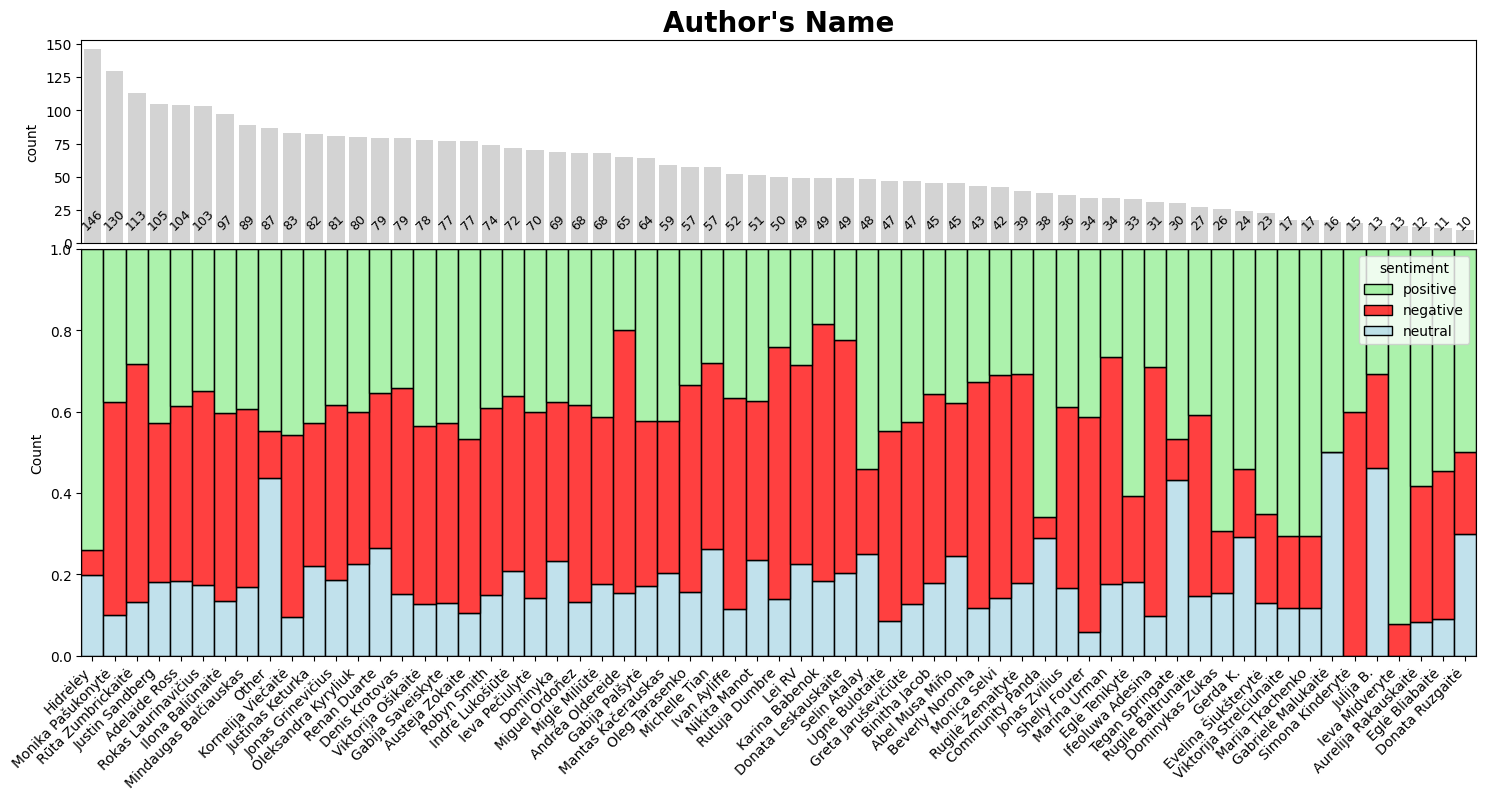

In [62]:
fig, axs = plt.subplots(figsize=(18,8), height_ratios=[4, 8], nrows=2)
plt.subplots_adjust(hspace=0.02)

sns.countplot(data=df_author_long,
              x="Author Name Shortened",
              palette=["lightgrey"],
              ax=axs[0])
axs[0].set_xticks([])
axs[0].set_xlabel(None)
axs[0].set_title("Author's Name", weight="bold", size=20)
for index, cat in enumerate(df_author_long_agg.index):
    count_val = df_author_long_agg["count"][cat]
    axs[0].text(y=10, x=index, s=count_val, ha="center", size=9, rotation=45)

sns.histplot(data=df_author_long,
             bins=len(df_author_long["Author Name Shortened"].unique()),
             x="Author Name Shortened",
             hue="sentiment",
             hue_order=["positive", "negative", "neutral"],
             palette=["lightgreen", "red", "lightblue"],
             multiple="fill",
             ax=axs[1])
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel(None);

#### Authors' Roles

In [63]:
# Sort by count and Author Role
df_author_long = df_author_long.sort_values(by=["role_count", "Author Role"], ascending=False)

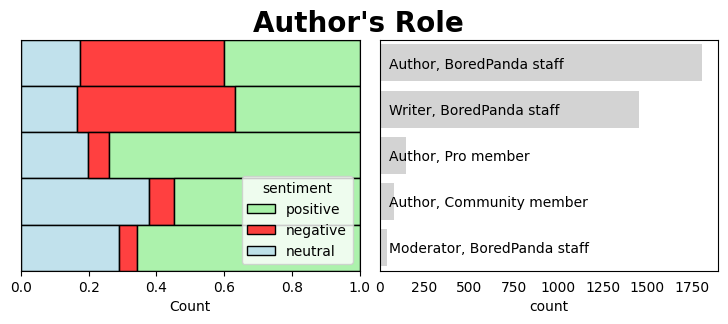

In [ ]:
fig, axs = plt.subplots(figsize=(9,3), ncols=2)
plt.subplots_adjust(wspace=0.06)
fig.suptitle("Author's Role", weight="bold", size=20)

sns.histplot(data=df_author_long,
             bins=len(df_author_long["Author Role"].unique()),
             y="Author Role",
             hue="sentiment",
             hue_order=["positive", "negative", "neutral"],
             palette=["lightgreen", "red", "lightblue"],
             multiple="fill",
             ax=axs[0])
axs[0].set_yticks([])
axs[0].set_ylabel(None)
sns.move_legend(axs[0], "lower right") 

sns.countplot(data=df_author_long,
              y="Author Role",
              palette=["lightgrey"],
              ax=axs[1])
axs[1].set_yticks(axs[1].get_yticks(), axs[1].get_yticklabels(), ha="left")
axs[1].tick_params(left=False, bottom=False)
axs[1].yaxis.set_tick_params(pad=-10)
axs[1].set_ylabel(None);

### Title (Wordclouds)

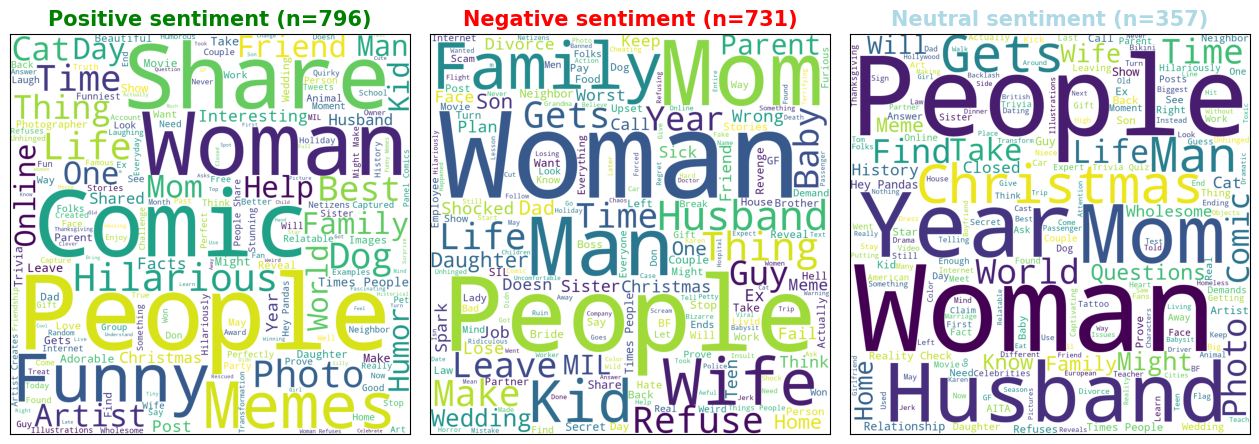

In [65]:
# Set up wordcloud module
stopwords = set(STOPWORDS)
stopwords.update(["re", "s", "t", "ve", "New", "Pics"])

wc = WordCloud(
    stopwords = stopwords,
    background_color = "white",
    width = 1000,
    height = 1000,
    min_font_size = 10
)

# Define canvas 
fig, axs = plt.subplots(figsize=(16,10), ncols=3)
plt.subplots_adjust(wspace=0.05)

# Create wordclouds of the post titles associated with the sentiments
sentiments = ["positive", "negative", "neutral"]
colors = ["green", "red", "lightblue"]
for axis, sentiment, color in zip(range(0,3), sentiments, colors):
    filtered_titles = df.loc[df["sentiment"] == sentiment, "title"]
    text = " ".join(filtered_titles)
    wordcloud = wc.generate(text)
    axs[axis].imshow(wordcloud)
    title_text = f"{sentiment.capitalize()} sentiment (n={len(filtered_titles)})"
    axs[axis].set_title(title_text, weight="bold", size=15, color=color)
    axs[axis].tick_params(left=False, bottom=False)
    axs[axis].set_xticklabels([])
    axs[axis].set_yticklabels([])